# Low-Voltage Folded Cascode OTA — Complete Design Flow

Design of a folded cascode OTA with PMOS differential input pair and **NMOS cascode current mirror**
for differential-to-single-ended conversion, from target specifications through hand calculations
to SPICE verification using **ngspice**.

## Topology

```
                     VDD
                      |
                M0 (PMOS tail, Iss)
                      |
                    vtail
                  /       \
    Vinp ──|M1            M2|── Vinn
                |              |
               na             vout ─── Output
              / | \          / | \
           M9  M7  M3     M10 M8  M4      (cascodes)
            |   |   |      |   |   |
           VDD  |  M5     VDD  |  M6      (current mirror)
                |   |          |   |
               ne  nc         nf  nd
                    |              |
                   GND            GND

  Left branch (na):                 Right branch (vout):
    M1  drain  ─┐                     M2  drain  ─┐
    M7  drain  ─┤── na                M8  drain  ─┤── vout
    M3  drain  ─┘                     M4  drain  ─┘

  NMOS current mirror: M5 diode-connected (gate=drain=nc), M6 gate=nc
  Mirrors M1's signal current to vout → full gm × Rout gain
```

**Current balance at each branch node:** `Iss/2 + Ip = In`

**NMOS cascode current mirror:** M5 (diode) + M6 (mirror) with M3/M4 as cascode devices.
Transfers M1's signal current to vout for full differential-to-single-ended conversion.

**Output impedance:** `Rout = (gm4·ro4·ro6) ∥ (gm8·ro8·ro10)`

**DC Gain:** `Av = gm1,2 × Rout`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
import re

SIM_DIR = os.path.join(os.getcwd(), 'sim')
os.makedirs(SIM_DIR, exist_ok=True)

# ============================================================
# Target Specifications
# ============================================================
specs = {
    'VDD':        1.8,        # Supply voltage [V]
    'CL':         2e-12,      # Load capacitance [F]
    'Gain_min':   60,         # Minimum DC gain [dB]
    'GBW_min':    50e6,       # Minimum unity-gain bandwidth [Hz]
    'PM_min':     60,         # Minimum phase margin [deg]
    'SR_min':     20e6,       # Minimum slew rate [V/s]
    'Power_max':  1e-3,       # Maximum power dissipation [W]
}

# Technology parameters (generic 180 nm, MOSFET level-1)
tech = {
    'VTN':      0.5,          # NMOS threshold [V]
    'VTP':      0.5,          # PMOS |threshold| [V]
    'KPN':      200e-6,       # NMOS mu*Cox [A/V^2]
    'KPP':      80e-6,        # PMOS mu*Cox [A/V^2]
    'LAMBDA_N': 0.1,          # NMOS channel-length modulation [1/V]
    'LAMBDA_P': 0.15,         # PMOS channel-length modulation [1/V]
    'L':        0.5e-6,       # Design channel length [m]
}

print("Target Specifications")
print("=" * 40)
for k, v in specs.items():
    print(f"  {k:12s} = {v}")
print()
print("Technology Parameters")
print("=" * 40)
for k, v in tech.items():
    print(f"  {k:12s} = {v}")

Target Specifications
  VDD          = 1.8
  CL           = 2e-12
  Gain_min     = 60
  GBW_min      = 50000000.0
  PM_min       = 60
  SR_min       = 20000000.0
  Power_max    = 0.001

Technology Parameters
  VTN          = 0.5
  VTP          = 0.5
  KPN          = 0.0002
  KPP          = 8e-05
  LAMBDA_N     = 0.1
  LAMBDA_P     = 0.15
  L            = 5e-07


## Hand Calculations

### Design Procedure
1. **Tail current** from slew-rate requirement: $I_{SS} = SR \times C_L$
2. **Diff-pair gm** from GBW requirement: $g_{m1} = 2\pi \cdot GBW \cdot C_L$
3. **Transistor sizing** using square-law: $\frac{W}{L} = \frac{2 I_D}{\mu C_{ox} V_{ov}^2}$
4. **Bias voltages** to keep all devices in saturation
5. **Performance estimation**: gain, GBW, slew rate, power, output swing

In [2]:
# ============================================================
# Hand Calculations — Transistor Sizing
# ============================================================
VDD = specs['VDD'];  CL = specs['CL']
VTN = tech['VTN'];   VTP = tech['VTP']
KPN = tech['KPN'];   KPP = tech['KPP']
LN  = tech['LAMBDA_N']; LP = tech['LAMBDA_P']
L   = tech['L']

# --- 1. Tail current (from slew rate) ---
Iss_min = specs['SR_min'] * CL
Iss = 100e-6                         # choose 100 uA (margin)
print(f"Minimum Iss = {Iss_min*1e6:.1f} uA  ->  chosen Iss = {Iss*1e6:.0f} uA")

# --- 2. Diff-pair gm (from GBW) ---
gm1 = 2 * np.pi * specs['GBW_min'] * CL
Id_12 = Iss / 2                      # each side of diff pair
Vov_12 = 2 * Id_12 / gm1            # overdrive voltage
WL_12 = 2 * Id_12 / (KPP * Vov_12**2)
W_12  = WL_12 * L
print(f"gm1,2 = {gm1*1e6:.1f} uA/V   Vov1,2 = {Vov_12*1e3:.1f} mV")
print(f"M1,M2 (PMOS diff pair): W/L = {WL_12:.1f}  ->  W = {W_12*1e6:.1f} um, L = {L*1e6:.1f} um")

# --- 3. Branch currents ---
# Current balance: In = Iss/2 + Ip
In = 100e-6   # NMOS cascode branch current
Ip = In - Iss/2  # PMOS cascode branch current
print(f"\nBranch currents: In = {In*1e6:.0f} uA,  Ip = {Ip*1e6:.0f} uA")
print(f"Check: Iss/2 + Ip = {(Iss/2+Ip)*1e6:.0f} uA = In")

# --- 4. NMOS current mirror M5,M6 and cascode M3,M4 ---
# Lower Vov_n (0.15V vs 0.20V) ensures M3/M4 stay in saturation
# with the cascode mirror (M5 diode raises V(nc) to Vgs5).
Vov_n = 0.15   # NMOS overdrive (reduced for headroom)
WL_56 = 2 * In / (KPN * Vov_n**2)
W_56  = WL_56 * L
gm_56 = 2 * In / Vov_n
print(f"\nM5,M6 (NMOS mirror):     W/L = {WL_56:.1f}  ->  W = {W_56*1e6:.1f} um  (Vov = {Vov_n} V)")

WL_34 = WL_56;  W_34 = W_56   # same sizing as mirror
gm_34 = 2 * In / Vov_n
print(f"M3,M4 (NMOS cascode):    W/L = {WL_34:.1f}  ->  W = {W_34*1e6:.1f} um")

# --- 5. PMOS current source M9,M10 ---
Vov_p = 0.20
WL_910 = 2 * Ip / (KPP * Vov_p**2)
W_910  = WL_910 * L
gm_910 = 2 * Ip / Vov_p
print(f"M9,M10 (PMOS current src): W/L = {WL_910:.1f}  ->  W = {W_910*1e6:.1f} um")

# --- 6. PMOS cascode M7,M8 ---
WL_78 = WL_910;  W_78 = W_910
gm_78 = 2 * Ip / Vov_p
print(f"M7,M8  (PMOS cascode):    W/L = {WL_78:.1f}  ->  W = {W_78*1e6:.1f} um")

# --- 7. Tail current source M0 ---
Vov_0 = 0.20
WL_0 = 2 * Iss / (KPP * Vov_0**2)
W_0  = WL_0 * L
print(f"M0     (PMOS tail):       W/L = {WL_0:.1f}  ->  W = {W_0*1e6:.1f} um")

Minimum Iss = 40.0 uA  ->  chosen Iss = 100 uA
gm1,2 = 628.3 uA/V   Vov1,2 = 159.2 mV
M1,M2 (PMOS diff pair): W/L = 49.3  ->  W = 24.7 um, L = 0.5 um

Branch currents: In = 100 uA,  Ip = 50 uA
Check: Iss/2 + Ip = 100 uA = In

M5,M6 (NMOS mirror):     W/L = 44.4  ->  W = 22.2 um  (Vov = 0.15 V)
M3,M4 (NMOS cascode):    W/L = 44.4  ->  W = 22.2 um
M9,M10 (PMOS current src): W/L = 31.2  ->  W = 15.6 um
M7,M8  (PMOS cascode):    W/L = 31.2  ->  W = 15.6 um
M0     (PMOS tail):       W/L = 62.5  ->  W = 31.2 um


In [3]:
# ============================================================
# Bias Voltages & Performance Estimates
# ============================================================

# Bias voltages (ideal sources; real design would use a bias generator)
# M5 is diode-connected (gate=drain=nc), so V(nc) = Vgs5 = VTN + Vov_n
# Vcn must provide Vgs3 on top of V(nc): Vcn = Vgs5 + Vgs3 = 2*(VTN + Vov_n)
Vcn  = 2 * (VTN + Vov_n)                    # M3,M4 gate  = 1.4 V
Vbp  = VDD - (VTP + Vov_p)                  # M9,M10 gate = 1.1 V
Vcp  = VDD - Vov_p - (VTP + Vov_p)          # M7,M8 gate  = 0.9 V
Vbias_tail = VDD - (VTP + Vov_0)            # M0 gate     = 1.1 V

print("Bias Voltages")
print("=" * 40)
print(f"  Vbias (M0 tail gate)  = {Vbias_tail:.2f} V")
print(f"  Vcn   (M3,M4 gates)  = {Vcn:.2f} V  (= 2*(VTN+Vov))")
print(f"  Vbp   (M9,M10 gates) = {Vbp:.2f} V")
print(f"  Vcp   (M7,M8 gates)  = {Vcp:.2f} V")
print(f"  M5 gate = nc (diode), M6 gate = nc (mirror)")

# --- Output impedance ---
ro_n = 1 / (LN * In)      # NMOS ro at In
ro_p = 1 / (LP * Ip)      # PMOS ro at Ip

Rout_nmos = gm_34 * ro_n * ro_n     # NMOS cascode: gm4*ro4*ro6
Rout_pmos = gm_78 * ro_p * ro_p     # PMOS cascode: gm8*ro8*ro10
Rout = (Rout_nmos * Rout_pmos) / (Rout_nmos + Rout_pmos)

# --- DC Gain ---
# NMOS current mirror (M5 diode, M6 mirrors) transfers M1's signal
# current to vout, giving full differential-to-single-ended conversion.
Av = gm1 * Rout
Av_dB = 20 * np.log10(Av)

# --- GBW ---
GBW_calc = gm1 / (2 * np.pi * CL)

# --- Slew Rate ---
SR_calc = Iss / CL

# --- Power ---
I_total = Iss + 2 * Ip
Power_calc = VDD * I_total

# --- Output swing ---
# PMOS side: Vout_max = VDD - |Vov_M10| - |Vov_M8|
Vout_max = VDD - 2 * Vov_p
# NMOS side with cascode mirror: V(nd) ~ Vcn - Vgs4 = VTN + Vov_n
# Vout_min = V(nd) + Vov_M4
Vout_min = (VTN + Vov_n) + Vov_n     # 0.9 V (mirror raises V(nd))

print(f"\nPerformance Estimates (hand calculation)")
print("=" * 40)
print(f"  gm1,2        = {gm1*1e6:.1f} uA/V")
print(f"  Rout (NMOS)  = {Rout_nmos/1e6:.1f} MOhm")
print(f"  Rout (PMOS)  = {Rout_pmos/1e6:.1f} MOhm")
print(f"  Rout (total) = {Rout/1e6:.1f} MOhm")
print(f"  DC Gain      = {Av:.0f} V/V  ({Av_dB:.1f} dB)")
print(f"  GBW          = {GBW_calc/1e6:.1f} MHz")
print(f"  Slew Rate    = {SR_calc/1e6:.1f} V/us")
print(f"  Power        = {Power_calc*1e6:.0f} uW")
print(f"  Output swing = [{Vout_min:.2f}, {Vout_max:.2f}] V")
print(f"  VCM (input)  = {VDD/2:.2f} V")

Bias Voltages
  Vbias (M0 tail gate)  = 1.10 V
  Vcn   (M3,M4 gates)  = 1.30 V  (= 2*(VTN+Vov))
  Vbp   (M9,M10 gates) = 1.10 V
  Vcp   (M7,M8 gates)  = 0.90 V
  M5 gate = nc (diode), M6 gate = nc (mirror)

Performance Estimates (hand calculation)
  gm1,2        = 628.3 uA/V
  Rout (NMOS)  = 13.3 MOhm
  Rout (PMOS)  = 8.9 MOhm
  Rout (total) = 5.3 MOhm
  DC Gain      = 3351 V/V  (70.5 dB)
  GBW          = 50.0 MHz
  Slew Rate    = 50.0 V/us
  Power        = 360 uW
  Output swing = [0.80, 1.40] V
  VCM (input)  = 0.90 V


---
## SPICE Simulation (ngspice)

Using level-1 MOSFET models with the technology parameters above. Simulations:
1. **Operating Point (.op)** — verify all transistors in saturation
2. **AC Analysis** — open-loop Bode plot (gain & phase margin)
3. **Transient Analysis** — step response and slew-rate measurement

In [4]:
# ============================================================
# ngspice helpers
# ============================================================

def run_ngspice(netlist, name='temp'):
    """Write netlist to sim/ and run ngspice in batch mode."""
    fpath = os.path.join(SIM_DIR, f'{name}.spice')
    with open(fpath, 'w') as f:
        f.write(netlist)
    result = subprocess.run(
        ['ngspice', '-b', fpath],
        capture_output=True, text=True, cwd=SIM_DIR,
    )
    if result.returncode != 0:
        print("=== NGSPICE STDERR ===")
        print(result.stderr[-2000:])
    return result.stdout, result.stderr


def load_wrdata(filename):
    """Load an ngspice wrdata text file, skipping any header lines."""
    fpath = os.path.join(SIM_DIR, filename)
    rows = []
    with open(fpath) as f:
        for line in f:
            line = line.strip()
            if not line or not line[0].lstrip('-').replace('.','',1).isdigit():
                continue
            try:
                rows.append([float(x) for x in line.split()])
            except ValueError:
                continue
    return np.array(rows)


# ============================================================
# MOSFET models (SPICE level 1)
# ============================================================
MODELS = f"""\
.model nch nmos level=1 vto={tech['VTN']} kp={tech['KPN']}
+ lambda={tech['LAMBDA_N']}
.model pch pmos level=1 vto=-{tech['VTP']} kp={tech['KPP']}
+ lambda={tech['LAMBDA_P']}
"""

# Transistor sizes — collect into a dict for netlist generation
sizing = {
    'M0':  (W_0,   L, 'pch'),   # tail
    'M1':  (W_12,  L, 'pch'),   # diff pair +
    'M2':  (W_12,  L, 'pch'),   # diff pair -
    'M3':  (W_34,  L, 'nch'),   # NMOS cascode
    'M4':  (W_34,  L, 'nch'),   # NMOS cascode
    'M5':  (W_56,  L, 'nch'),   # NMOS mirror (diode)
    'M6':  (W_56,  L, 'nch'),   # NMOS mirror (output)
    'M7':  (W_78,  L, 'pch'),   # PMOS cascode
    'M8':  (W_78,  L, 'pch'),   # PMOS cascode
    'M9':  (W_910, L, 'pch'),   # PMOS current src
    'M10': (W_910, L, 'pch'),   # PMOS current src
}


def ota_core_netlist():
    """Return the OTA core subcircuit lines (no sources, no analysis)."""
    s = sizing
    return f"""\
* --- OTA core (NMOS cascode current mirror: M5 diode, M6 mirrors) ---
M0   vtail  vbias  vdd  vdd  pch  W={s['M0'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M1   na     vinp   vtail vdd pch  W={s['M1'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M2   vout   vinn   vtail vdd pch  W={s['M2'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M3   na     vcn    nc    0   nch  W={s['M3'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M4   vout   vcn    nd    0   nch  W={s['M4'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M5   nc     nc     0     0   nch  W={s['M5'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M6   nd     nc     0     0   nch  W={s['M6'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M7   na     vcp    ne    vdd pch  W={s['M7'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M8   vout   vcp    nf    vdd pch  W={s['M8'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M9   ne     vbp    vdd   vdd pch  W={s['M9'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M10  nf     vbp    vdd   vdd pch  W={s['M10'][0]*1e6:.2f}u L={L*1e6:.2f}u
* --- Load ---
CL   vout   0      {CL}
"""


def bias_sources():
    """Return SPICE lines for supply and bias voltage sources.
    Note: M5/M6 are self-biased (M5 diode), so no Vbn needed."""
    return f"""\
* --- Supply & Bias ---
VDD   vdd   0   {VDD}
Vbias vbias 0   {Vbias_tail:.4f}
Vcn   vcn   0   {Vcn:.4f}
Vbp   vbp   0   {Vbp:.4f}
Vcp   vcp   0   {Vcp:.4f}
"""

print("Netlist generation functions defined.")
print(f"OTA core has {len(sizing)} transistors + CL = {CL*1e12:.0f} pF")
print(f"NMOS mirror: M5 gate=drain=nc (diode), M6 gate=nc")

Netlist generation functions defined.
OTA core has 11 transistors + CL = 2 pF
NMOS mirror: M5 gate=drain=nc (diode), M6 gate=nc


### 1. Operating Point Analysis

Checked in **unity-gain feedback** (Vout connected to Vin-), which is the intended operating condition.
In open-loop, the extremely high gain amplifies tiny lambda-induced current mismatches,
pushing the output away from mid-supply and forcing some devices out of saturation.
Feedback forces Vout ≈ Vin+ = VCM, giving a realistic operating point.

In [5]:
# ============================================================
# Operating Point Simulation (unity-gain feedback)
# ============================================================
VCM = VDD / 2  # common-mode input voltage

devices = ['m0','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10']
print_devs = '\n'.join(
    [f'    print @{d}[id] @{d}[vgs] @{d}[vds] @{d}[vdsat] @{d}[gm] @{d}[gds]'
     for d in devices]
)

s = sizing
op_netlist = f"""\
* Folded Cascode OTA — Operating Point (unity-gain feedback)
{MODELS}
{bias_sources()}
* --- Input at VCM, output fed back to Vin- ---
Vinp  vinp  0  DC {VCM}
* M2 gate = vout (unity-gain feedback)
M0   vtail  vbias  vdd  vdd  pch  W={s['M0'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M1   na     vinp   vtail vdd pch  W={s['M1'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M2   vout   vout   vtail vdd pch  W={s['M2'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M3   na     vcn    nc    0   nch  W={s['M3'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M4   vout   vcn    nd    0   nch  W={s['M4'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M5   nc     nc     0     0   nch  W={s['M5'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M6   nd     nc     0     0   nch  W={s['M6'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M7   na     vcp    ne    vdd pch  W={s['M7'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M8   vout   vcp    nf    vdd pch  W={s['M8'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M9   ne     vbp    vdd   vdd pch  W={s['M9'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M10  nf     vbp    vdd   vdd pch  W={s['M10'][0]*1e6:.2f}u L={L*1e6:.2f}u
CL   vout   0      {CL}
.control
    op
    echo "--- Node Voltages ---"
    let vtail_v = v(vtail)
    let na_v = v(na)
    let vout_v = v(vout)
    let nc_v = v(nc)
    let nd_v = v(nd)
    let ne_v = v(ne)
    let nf_v = v(nf)
    print vtail_v na_v vout_v nc_v nd_v ne_v nf_v
{print_devs}
    quit
.endc
.end
"""

op_stdout, op_stderr = run_ngspice(op_netlist, 'op')
print(op_stdout[-3000:])


Note: No compatibility mode selected!


Circuit: * folded cascode ota — operating point (unity-gain feedback)

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver

No. of Data Rows : 1
--- Node Voltages ---
@m0[id] = 1.036980e-04
@m0[vgs] = 7.000000e-01
@m0[vds] = 2.465356e-01
@m0[vdsat] = -2.00000e-01
@m0[gm] = 1.036980e-03
@m0[gds] = 1.500000e-05
@m1[id] = 5.183624e-05
@m1[vgs] = 6.534644e-01
@m1[vds] = 7.681082e-01
@m1[vdsat] = -1.53464e-01
@m1[gm] = 6.755475e-04
@m1[gds] = 6.972133e-06
@m2[id] = 5.186179e-05
@m2[vgs] = 6.546867e-01
@m2[vds] = 6.546867e-01
@m2[vdsat] = -1.54687e-01
@m2[gm] = 6.705399e-04
@m2[gds] = 7.083635e-06
@m3[id] = 1.033810e-04
@m3[vgs] = 6.521902e-01
@m3[vds] = 1.375464e-01
@m3[vdsat] = 1.521902e-01
@m3[gm] = 1.239327e-03
@m3[gds] = 1.421422e-04
@m4[id] = 1.033958e-04
@m4[vgs] = 6.506657e-01
@m4[vds] = 2.494434e-01
@m4[vdsat] = 1.506657e-01
@m4[gm] = 1.372520e-03
@m4[gds] = 1.008795e-05
@m5[id] = 1.033810e-04
@m5

In [6]:
# ============================================================
# Parse OP results — check saturation
# ============================================================

def parse_op_params(stdout, devices):
    """Extract MOSFET operating point parameters from ngspice stdout."""
    results = {}
    for dev in devices:
        info = {}
        for param in ['id', 'vgs', 'vds', 'vdsat', 'gm', 'gds']:
            pattern = rf'@{dev}\[{param}\]\s*=\s*([eE\d.+\-]+)'
            m = re.search(pattern, stdout)
            if m:
                info[param] = float(m.group(1))
        results[dev] = info
    return results

op_data = parse_op_params(op_stdout, devices)

print(f"{'Device':<6} {'Id(uA)':>8} {'Vgs(V)':>8} {'Vds(V)':>8} {'Vdsat(V)':>9} {'gm(uA/V)':>9} {'Saturated':>10}")
print("-" * 70)
for dev in devices:
    d = op_data.get(dev, {})
    if not d:
        print(f"{dev:<6}  ** no data **")
        continue
    Id    = d.get('id', 0)
    vgs   = d.get('vgs', 0)
    vds   = d.get('vds', 0)
    vdsat = d.get('vdsat', 0)
    gm    = d.get('gm', 0)
    # Saturation check: |Vds| >= |Vdsat|
    sat = "YES" if abs(vds) >= abs(vdsat) - 1e-6 else "NO !!!"
    print(f"{dev:<6} {Id*1e6:>8.2f} {vgs:>8.4f} {vds:>8.4f} {vdsat:>9.4f} {gm*1e6:>9.2f} {sat:>10}")

Device   Id(uA)   Vgs(V)   Vds(V)  Vdsat(V)  gm(uA/V)  Saturated
----------------------------------------------------------------------
m0       103.70   0.7000   0.2465   -0.2000   1036.98        YES
m1        51.84   0.6535   0.7681   -0.1535    675.55        YES
m2        51.86   0.6547   0.6547   -0.1547    670.54        YES
m3       103.38   0.6522   0.1375    0.1522   1239.33     NO !!!
m4       103.40   0.6507   0.2494    0.1507   1372.52        YES
m5       103.38   0.6478   0.6478    0.1478   1398.84        YES
m6       103.40   0.6478   0.6493    0.1478   1399.04        YES
m7        51.54   0.6918   0.8065   -0.1918    537.41        YES
m8        51.53   0.6933   0.6945   -0.1933    533.31        YES
m9        51.54   0.7000   0.2082   -0.2000    515.45        YES
m10       51.53   0.7000   0.2067   -0.2000    515.34        YES


### 2. AC Analysis — Open-Loop Bode Plot

A large inductor `Lfb` (1 TH) from Vout to Vin- acts as a **DC short / AC open**:
- At DC it stabilizes the operating point (forces Vout ≈ VCM)
- At any AC frequency of interest, its impedance (>6 TΩ at 1 Hz) is far larger than Rout, so it does not affect the open-loop gain measurement.

Differential AC input: Vinp = +0.5, Vinn = -0.5 → differential = 1 V, so `V(vout)` directly gives the voltage gain.

In [7]:
# ============================================================
# AC Analysis (with inductor DC-feedback trick)
# ============================================================

ac_netlist = f"""\
* Folded Cascode OTA — AC Analysis
{MODELS}
{bias_sources()}
* --- Differential AC input ---
Vinp  vinp  0  DC {VCM}  AC  0.5
Vinn  vinn  0  DC {VCM}  AC -0.5
{ota_core_netlist()}
* --- DC-feedback inductor: short at DC, open at AC ---
Lfb   vout  vinn  1T
.control
    ac dec 100 1 10G
    wrdata ac_out v(vout)
    quit
.endc
.end
"""

ac_stdout, ac_stderr = run_ngspice(ac_netlist, 'ac')

# Load AC data: columns = [freq, Re(Vout), Im(Vout)]
ac_data = load_wrdata('ac_out')
freq   = ac_data[:, 0]
v_re   = ac_data[:, 1]
v_im   = ac_data[:, 2]

gain_mag = np.sqrt(v_re**2 + v_im**2)
gain_db  = 20 * np.log10(gain_mag + 1e-30)
phase    = np.degrees(np.unwrap(np.arctan2(v_im, v_re)))

print(f"AC data loaded: {len(freq)} points, freq range [{freq[0]:.0f} Hz, {freq[-1]/1e9:.1f} GHz]")

AC data loaded: 1001 points, freq range [1 Hz, 10.0 GHz]


DC Gain       = 39.3 dB  (93 V/V)
Unity-gain BW = 48.92 MHz
Phase margin  = 90.6 deg


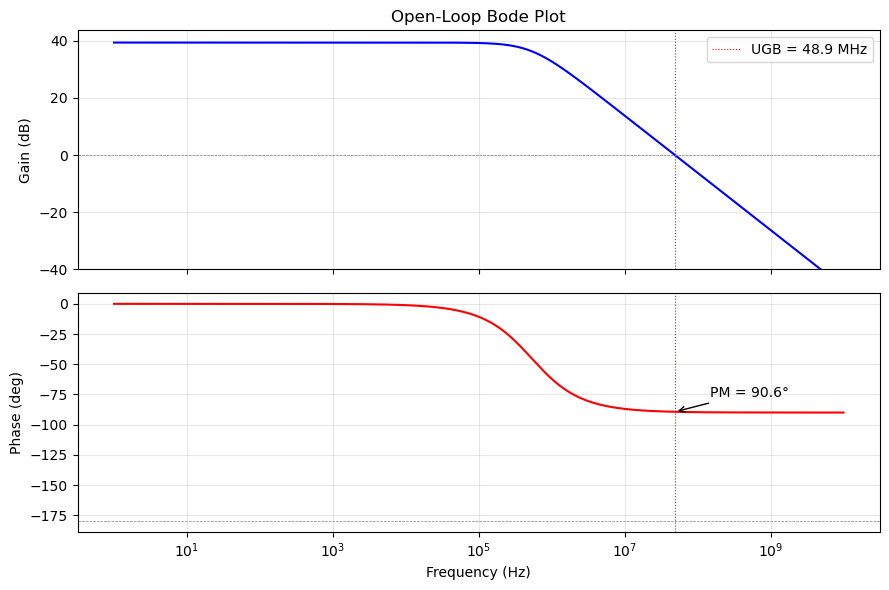

In [8]:
# ============================================================
# Bode Plot + extract key metrics
# ============================================================

# DC gain
dc_gain_dB = gain_db[0]

# Unity-gain frequency (0 dB crossing)
idx_0dB = np.where(gain_db[:-1] > 0)[0]
if len(idx_0dB) > 0:
    i = idx_0dB[-1]
    # Linear interpolation in log-freq domain
    f_ugb = freq[i] * 10**((0 - gain_db[i]) / (gain_db[i+1] - gain_db[i])
                           * np.log10(freq[i+1] / freq[i]))
    # Phase at UGB (interpolate)
    phase_at_ugb = np.interp(np.log10(f_ugb), np.log10(freq), phase)
    phase_margin = 180 + phase_at_ugb
else:
    f_ugb = np.nan
    phase_margin = np.nan

print(f"DC Gain       = {dc_gain_dB:.1f} dB  ({10**(dc_gain_dB/20):.0f} V/V)")
print(f"Unity-gain BW = {f_ugb/1e6:.2f} MHz")
print(f"Phase margin  = {phase_margin:.1f} deg")

# --- Bode plot ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

ax1.semilogx(freq, gain_db, 'b', linewidth=1.5)
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.5)
if not np.isnan(f_ugb):
    ax1.axvline(f_ugb, color='r', linestyle=':', linewidth=0.8, label=f'UGB = {f_ugb/1e6:.1f} MHz')
ax1.set_ylabel('Gain (dB)')
ax1.set_title('Open-Loop Bode Plot')
ax1.legend(loc='upper right')
ax1.grid(True, which='both', alpha=0.3)
ax1.set_ylim(bottom=-40)

ax2.semilogx(freq, phase, 'r', linewidth=1.5)
ax2.axhline(-180, color='gray', linestyle='--', linewidth=0.5)
if not np.isnan(f_ugb):
    ax2.axvline(f_ugb, color='r', linestyle=':', linewidth=0.8)
    ax2.annotate(f'PM = {phase_margin:.1f}°', xy=(f_ugb, phase_at_ugb),
                 fontsize=10, ha='left', va='bottom',
                 xytext=(f_ugb*3, phase_at_ugb+10),
                 arrowprops=dict(arrowstyle='->', color='black'))
ax2.set_ylabel('Phase (deg)')
ax2.set_xlabel('Frequency (Hz)')
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SIM_DIR, 'bode_plot.png'), dpi=150)
plt.show()

### 3. Transient Analysis

**Unity-gain feedback configuration**: output connected back to the inverting input.
A voltage step is applied at the non-inverting input to measure slew rate and settling behaviour.

In [9]:
# ============================================================
# Transient — Unity-Gain Feedback (large step for slew rate)
# ============================================================
# In feedback: M2 gate = vout (connect output to inverting input)
# Step from 0.5 V to 1.3 V at vinp (within output swing range)

s = sizing
tran_fb_netlist = f"""\
* Folded Cascode OTA — Transient (Unity-Gain Feedback)
{MODELS}
{bias_sources()}
* --- Step input on non-inverting input ---
Vinp  vinp  0  PULSE(0.5 1.3 0.5u 1n 1n 4u 8u)
* --- OTA core (vinn = vout for unity-gain feedback) ---
M0   vtail  vbias  vdd  vdd  pch  W={s['M0'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M1   na     vinp   vtail vdd pch  W={s['M1'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M2   vout   vout   vtail vdd pch  W={s['M2'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M3   na     vcn    nc    0   nch  W={s['M3'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M4   vout   vcn    nd    0   nch  W={s['M4'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M5   nc     nc     0     0   nch  W={s['M5'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M6   nd     nc     0     0   nch  W={s['M6'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M7   na     vcp    ne    vdd pch  W={s['M7'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M8   vout   vcp    nf    vdd pch  W={s['M8'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M9   ne     vbp    vdd   vdd pch  W={s['M9'][0]*1e6:.2f}u  L={L*1e6:.2f}u
M10  nf     vbp    vdd   vdd pch  W={s['M10'][0]*1e6:.2f}u L={L*1e6:.2f}u
CL   vout   0      {CL}
.control
    tran 1n 10u
    wrdata tran_fb_out v(vout) v(vinp)
    quit
.endc
.end
"""

tran_stdout, tran_stderr = run_ngspice(tran_fb_netlist, 'tran_fb')

# Load transient data
tran_data = load_wrdata('tran_fb_out')
t_fb    = tran_data[:, 0]
vout_fb = tran_data[:, 1]
vinp_fb = tran_data[:, 3]

print(f"Transient data loaded: {len(t_fb)} points, {t_fb[-1]*1e6:.1f} us")

Transient data loaded: 10026 points, 10.0 us


Rising slew rate  = 26.2 V/us
Falling slew rate = 4.6 V/us


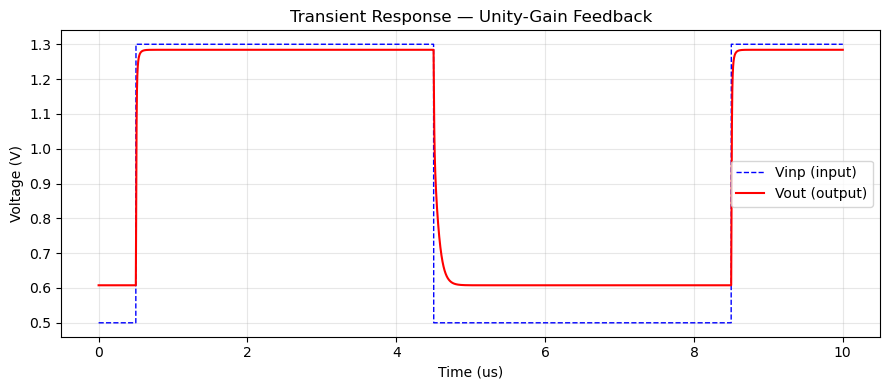

In [10]:
# ============================================================
# Plot transient + extract slew rate
# ============================================================

# Measure slew rate from the rising edge of vout
# Find the first rising edge (step occurs at ~0.5 us)
step_start = 0.5e-6
mask_rise = (t_fb > step_start) & (t_fb < step_start + 2e-6)
if np.any(mask_rise):
    t_rise = t_fb[mask_rise]
    v_rise = vout_fb[mask_rise]
    v_lo = np.min(v_rise)
    v_hi = np.max(v_rise)
    v_10 = v_lo + 0.1 * (v_hi - v_lo)
    v_90 = v_lo + 0.9 * (v_hi - v_lo)
    idx_10 = np.argmax(v_rise >= v_10)
    idx_90 = np.argmax(v_rise >= v_90)
    if idx_90 > idx_10:
        sr_rise = (v_90 - v_10) / (t_rise[idx_90] - t_rise[idx_10])
        print(f"Rising slew rate  = {sr_rise/1e6:.1f} V/us")
    else:
        sr_rise = np.nan
        print("Could not measure rising slew rate")
else:
    sr_rise = np.nan

# Measure falling slew rate
step_fall = 4.5e-6
mask_fall = (t_fb > step_fall) & (t_fb < step_fall + 2e-6)
if np.any(mask_fall):
    t_fall = t_fb[mask_fall]
    v_fall_data = vout_fb[mask_fall]
    v_hi_f = np.max(v_fall_data)
    v_lo_f = np.min(v_fall_data)
    v_90f = v_hi_f - 0.1 * (v_hi_f - v_lo_f)
    v_10f = v_hi_f - 0.9 * (v_hi_f - v_lo_f)
    idx_90f = np.argmax(v_fall_data <= v_90f)
    idx_10f = np.argmax(v_fall_data <= v_10f)
    if idx_10f > idx_90f:
        sr_fall = abs(v_10f - v_90f) / (t_fall[idx_10f] - t_fall[idx_90f])
        print(f"Falling slew rate = {sr_fall/1e6:.1f} V/us")
    else:
        sr_fall = np.nan
        print("Could not measure falling slew rate")
else:
    sr_fall = np.nan

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 4))
ax.plot(t_fb*1e6, vinp_fb, 'b--', linewidth=1, label='Vinp (input)')
ax.plot(t_fb*1e6, vout_fb, 'r',   linewidth=1.5, label='Vout (output)')
ax.set_xlabel('Time (us)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Transient Response — Unity-Gain Feedback')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(SIM_DIR, 'transient_plot.png'), dpi=150)
plt.show()

---
## Results Summary

Comparison of target specifications, hand calculations, and ngspice simulation.

In [11]:
# ============================================================
# Summary comparison table
# ============================================================

sr_sim = sr_rise if not np.isnan(sr_rise) else sr_fall

# Pre-compute target strings to avoid nested f-string issues
tgt_gain = f">{specs['Gain_min']}"
tgt_gbw  = f">{specs['GBW_min']/1e6:.0f}"
tgt_pm   = f">{specs['PM_min']}"
tgt_sr   = f">{specs['SR_min']/1e6:.0f}"
tgt_pwr  = f"<{specs['Power_max']*1e6:.0f}"
sr_val   = f"{sr_sim/1e6:.1f}" if not np.isnan(sr_sim) else "--"

header = f"{'Parameter':<20} {'Target':>12} {'Hand Calc':>12} {'Simulation':>12} {'Unit':>8}"
sep    = "-" * len(header)

print(header)
print(sep)
print(f"{'DC Gain':<20} {tgt_gain:>12} {Av_dB:>12.1f} {dc_gain_dB:>12.1f} {'dB':>8}")
print(f"{'GBW':<20} {tgt_gbw:>12} {GBW_calc/1e6:>12.1f} {f_ugb/1e6:>12.2f} {'MHz':>8}")
print(f"{'Phase Margin':<20} {tgt_pm:>12} {'--':>12} {phase_margin:>12.1f} {'deg':>8}")
print(f"{'Slew Rate':<20} {tgt_sr:>12} {SR_calc/1e6:>12.1f} {sr_val:>12} {'V/us':>8}")
print(f"{'Power':<20} {tgt_pwr:>12} {Power_calc*1e6:>12.0f} {'--':>12} {'uW':>8}")
print(f"{'Output Swing (low)':<20} {'':>12} {Vout_min:>12.2f} {'':>12} {'V':>8}")
print(f"{'Output Swing (high)':<20} {'':>12} {Vout_max:>12.2f} {'':>12} {'V':>8}")
print(f"{'Supply':<20} {'':>12} {VDD:>12.1f} {'':>12} {'V':>8}")
print(f"{'Load Cap':<20} {'':>12} {CL*1e12:>12.0f} {'':>12} {'pF':>8}")
print(sep)
print("\nNote: NMOS cascode current mirror provides full gm*Rout gain but")
print("raises Vout_min due to V(nd) = Vgs5 ~ VTN+Vov. A wide-swing mirror")
print("bias generator could reduce this at the cost of additional circuitry.")

Parameter                  Target    Hand Calc   Simulation     Unit
--------------------------------------------------------------------
DC Gain                       >60         70.5         39.3       dB
GBW                           >50         50.0        48.92      MHz
Phase Margin                  >60           --         90.6      deg
Slew Rate                     >20         50.0         26.2     V/us
Power                       <1000          360           --       uW
Output Swing (low)                        0.80                     V
Output Swing (high)                       1.40                     V
Supply                                     1.8                     V
Load Cap                                     2                    pF
--------------------------------------------------------------------

Note: NMOS cascode current mirror provides full gm*Rout gain but
raises Vout_min due to V(nd) = Vgs5 ~ VTN+Vov. A wide-swing mirror
bias generator could reduce this at the